<a href="https://colab.research.google.com/github/pragatipatel26/Activity_Recognition/blob/main/human_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import zipfile
import io
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Function to download and load dataset
def load_data():
    page_url = 'https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones'
    page_response = requests.get(page_url)
    if page_response.status_code == 200:
        soup = BeautifulSoup(page_response.content, 'html.parser')
        download_link = soup.select_one('a[href$=".zip"]')['href']
        full_download_url = 'https://archive.ics.uci.edu' + download_link
        response = requests.get(full_download_url)
        if response.status_code == 200:
            with zipfile.ZipFile(io.BytesIO(response.content)) as outer_zip:
                inner_zip_name = 'UCI HAR Dataset.zip'
                with outer_zip.open(inner_zip_name) as inner_zip_file:
                    with zipfile.ZipFile(io.BytesIO(inner_zip_file.read())) as inner_zip:
                        with inner_zip.open('UCI HAR Dataset/train/X_train.txt') as myfile:
                            df = pd.read_csv(myfile, delim_whitespace=True, header=None)
                        with inner_zip.open('UCI HAR Dataset/train/y_train.txt') as myfile_y:
                            y = pd.read_csv(myfile_y, delim_whitespace=True, header=None)
    else:
        raise Exception("Failed to download or parse the dataset.")
    return df, y

In [ ]:
# Load dataset
df, y = load_data()

<ipython-input-3-af53a6110993>:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(myfile, delim_whitespace=True, header=None)
<ipython-input-3-af53a6110993>:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(myfile_y, delim_whitespace=True, header=None)


In [ ]:
#DO EDA and understand a little about the data.
#Only important thing is to know that it has a lot of features that don't make sense, just a
#bunch of readings from sensors.
#We think many of these features are redundant or irrelevant, and we want to find good features.

#number of rows and columns in dataset
print(df.shape)
#number of features=561
print(df.head(5))
#data preprocessing
#we are dividing data into catagorical,int andd float datatypes
#data preprocessing
#we are dividing data into catagorical,int andd float datatypes
obj= (df.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_= (df.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl= (df.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))
#all of the 561 features are floating values

print(df.info())
print(y.info())

#check for missing values
print("Missing Values:\n", df.isnull().sum())

# Check for duplicate rows
print("Duplicate Rows:", df.duplicated().sum())




(7352, 561)
        0         1         2         3         4         5         6    \
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2  0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3  0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4  0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   

        7         8         9    ...       551       552       553       554  \
0 -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304 -0.112754   
1 -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499  0.053477   
2 -0.963668 -0.977469 -0.938692  ...  0.414503 -0.390748 -0.760104 -0.118559   
3 -0.982750 -0.989302 -0.938692  ...  0.404573 -0.117290 -0.482845 -0.036788   
4 -0.979672 -0.990441 -0.942469  ...  0.087753 -0.351471 -0.699205  0.123320   

        555       556       557       558       559     

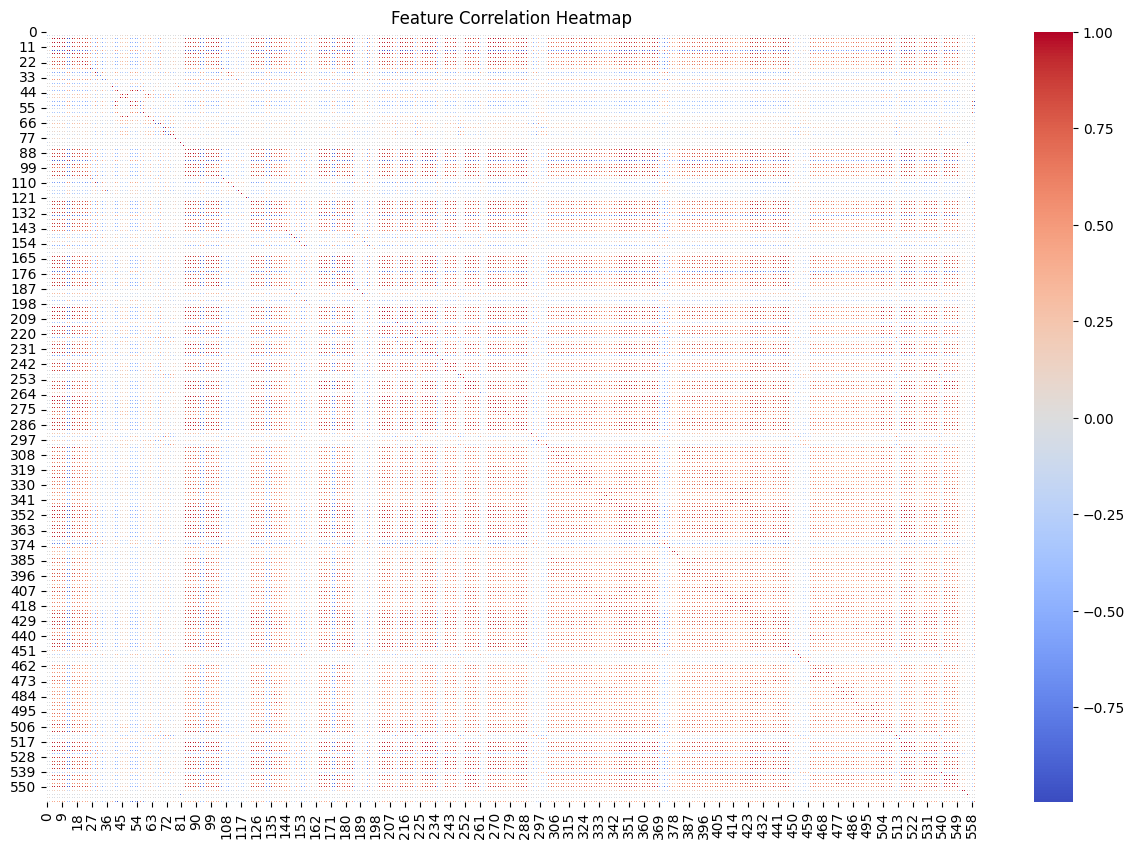

Number of highly correlated pairs: 8206


In [ ]:
# Calculate correlation matrix
corr_matrix = df.corr()

# Plot a heatmap of the correlations
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

#setting a threshold
threshold=0.9
highly_correlated_features = 0
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:  # If correlation is above the threshold
            highly_correlated_features+= 1

print("Number of highly correlated pairs:", highly_correlated_features)

In [ ]:
#Encode class labels
#since we have 0 categorical variable in df so we are applying labelencoder in y only
y = y.squeeze()
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y)
print(encoded_y)

[4 4 4 ... 1 1 1]


In [ ]:
# Scale the features using StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


In [ ]:
# Split the data into training and testing sets
X_train_full, X_test_full, y_train, y_test = train_test_split(df_scaled, encoded_y, test_size=0.2, random_state=42)
# Define a Pipeline with Gaussian Naive Bayes and train it on the full dataset
from sklearn.naive_bayes import GaussianNB
start_time = time.time()
classifier_pipeline_full = Pipeline([
    ('classifier', GaussianNB())])
classifier_pipeline_full.fit(X_train_full, y_train)
y_pred_full = classifier_pipeline_full.predict(X_test_full)
end_time = time.time()
full_features_time = end_time - start_time
accuracy_full = accuracy_score(y_test, y_pred_full)
print(accuracy_full)

0.7314751869476547


In [ ]:
# Perform K-Means clustering for dimensionality reduction
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(df_scaled.T)


KMeans(n_clusters=50, n_init=10, random_state=42)

In [ ]:
selected_features_indices = [np.random.choice(np.where(kmeans.labels_ == i)[0]) for i in range(n_clusters)]
selected_features = df_scaled[:, selected_features_indices]


In [ ]:
# Split the data with reduced features for training and testing
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(selected_features, encoded_y, test_size=0.2, random_state=42)


In [ ]:
#Implement and train a NB model on the reduced feature set
start_time = time.time()
classifier_pipeline_reduced = Pipeline([
    ('classifier', GaussianNB())
])
classifier_pipeline_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = classifier_pipeline_reduced.predict(X_test_reduced)
end_time = time.time()
reduced_features_time = end_time - start_time
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
print(accuracy_reduced)

0.8123725356900068


In [ ]:
# Print accuracy and training time for both models
print("Baseline Model (All Features):")
print("Accuracy:", accuracy_full)
print("Training Time:", full_features_time, "seconds")
print("Number of Features:", X_train_full.shape[1])

print("\nModel with Reduced Features (K-Means):")
print("Accuracy:", accuracy_reduced)
print("Training Time:", reduced_features_time, "seconds")
print("Number of Features:", n_clusters)


Baseline Model (All Features):
Accuracy: 0.7314751869476547
Training Time: 0.3725905418395996 seconds
Number of Features: 561

Model with Reduced Features (K-Means):
Accuracy: 0.8123725356900068
Training Time: 0.023424148559570312 seconds
Number of Features: 50


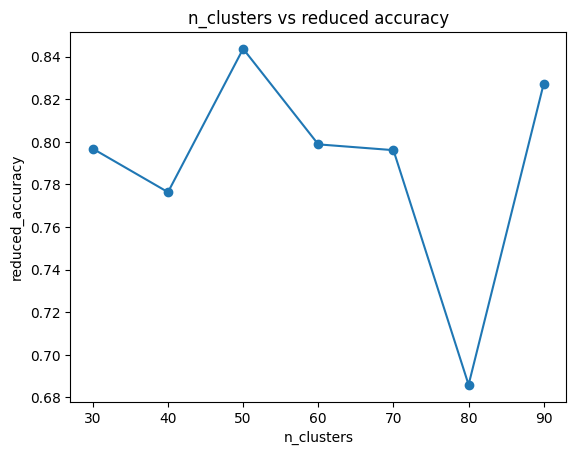

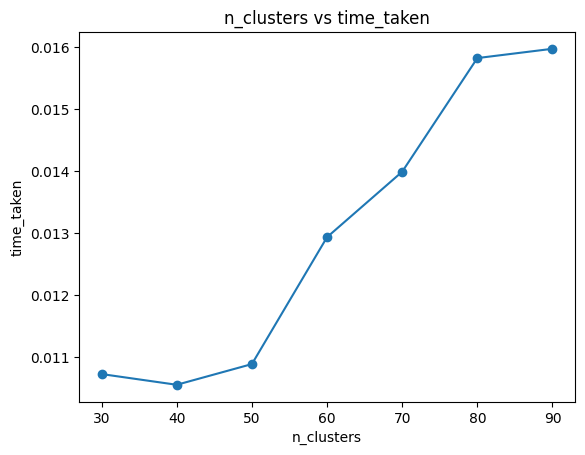

In [ ]:
n_clusters = 30
clusters=[]
time_taken=[]
new_accuracy=[]
while n_clusters < 100:
  clusters.append(n_clusters)
  kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
  kmeans.fit(df_scaled.T)
  selected_features_indices = [np.random.choice(np.where(kmeans.labels_ == i)[0]) for i in range(n_clusters)]
  selected_features = df_scaled[:, selected_features_indices]
  X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(selected_features, encoded_y, test_size=0.2, random_state=42)
  start_time = time.time()
  classifier_pipeline_reduced = Pipeline([
    ('classifier', GaussianNB())
   ])
  classifier_pipeline_reduced.fit(X_train_reduced, y_train)
  y_pred_reduced = classifier_pipeline_reduced.predict(X_test_reduced)
  end_time = time.time()
  reduced_features_time = end_time - start_time
  time_taken.append(reduced_features_time)
  accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
  new_accuracy.append(accuracy_reduced)
  n_clusters+=10

plt.plot(clusters, new_accuracy, marker='o')

# Labeling the axes and adding title for n_clusters vs reduced accuracy
plt.xlabel('n_clusters')
plt.ylabel('reduced_accuracy')
plt.title('n_clusters vs reduced accuracy')

# Display the plot
plt.show()

plt.plot(clusters, time_taken, marker='o')

# Labeling the axes and adding title for n_clusters vs time_taken
plt.xlabel('n_clusters')
plt.ylabel('time_taken')
plt.title('n_clusters vs time_taken')

# Display the plot
plt.show()